### A quantum implementation of an actor critic RL model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_quantum as tfq
from tensorflow import keras
import gym
import cirq
import sympy


from cirq.contrib.svg import SVGCircuit
from functools import reduce
from collections import deque, defaultdict

2024-07-18 22:31:06.144484: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-18 22:31:06.195288: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-18 22:31:06.195324: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-18 22:31:06.196759: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-18 22:31:06.205140: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-18 22:31:06.205602: I tensorflow/core/platform/cpu_feature_guard.cc:1

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

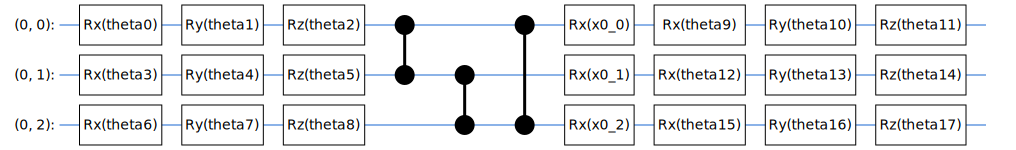

In [2]:
def one_qubit_rotation(qubit, symbols):
    """
    Returns Cirq gates that apply a rotation of the bloch sphere about the X,
    Y and Z axis, specified by the values in `symbols`.
    """
    return [cirq.rx(symbols[0])(qubit), cirq.ry(symbols[1])(qubit), cirq.rz(symbols[2])(qubit)]

def entangling_layer(qubits):
    """
    Returns a layer of CZ entangling gates on `qubits` (arranged in a circular topology).
    """
    # cz_ops = [cirq.CZ(q0, q1) for q0, q1 in zip(qubits, qubits[1:])]
    # cz_ops += ([cirq.CZ(qubits[0], qubits[-1])] if len(qubits) != 2 else [])
    return [cirq.CZ(q0, q1) for q0, q1 in zip(qubits, np.roll(qubits, -1, axis=0))]

def generate_circuit(qubits, n_layers):
    """Prepares a data re-uploading circuit on `qubits` with `n_layers` layers."""
    # Number of qubits
    n_qubits = len(qubits)

    # Sympy symbols for variational angles
    params = sympy.symbols(f'theta(0:{3*(n_layers+1)*n_qubits})')
    params = np.asarray(params).reshape((n_layers + 1, n_qubits, 3))

    # Sympy symbols for encoding angles
    inputs = sympy.symbols(f'x(0:{n_layers})'+f'_(0:{n_qubits})')
    inputs = np.asarray(inputs).reshape((n_layers, n_qubits))

    # Define circuit
    circuit = cirq.Circuit()
    for l in range(n_layers):
        # Variational layer
        circuit += cirq.Circuit(one_qubit_rotation(q, params[l, i]) for i, q in enumerate(qubits))
        circuit += entangling_layer(qubits)
        # Encoding layer
        circuit += cirq.Circuit(cirq.rx(inputs[l, i])(q) for i, q in enumerate(qubits))

    # Last varitional layer
    circuit += cirq.Circuit(one_qubit_rotation(q, params[n_layers, i]) for i,q in enumerate(qubits))

    return circuit, list(params.flat), list(inputs.flat)

n_qubits, n_layers = 3, 1
qubits = cirq.GridQubit.rect(1, n_qubits)
circuit, _, _ = generate_circuit(qubits, n_layers)
SVGCircuit(circuit)
    
# class QActorCritic:
#     def __init__(self):
#         self.circuit = 


In [3]:
class ReUploadingPQC(tf.keras.layers.Layer):
    """
    Performs the transformation (s_1, ..., s_d) -> (theta_1, ..., theta_N, lmbd[1][1]s_1, ..., lmbd[1][M]s_1,
        ......., lmbd[d][1]s_d, ..., lmbd[d][M]s_d) for d=input_dim, N=theta_dim and M=n_layers.
    An activation function from tf.keras.activations, specified by `activation` ('linear' by default) is
        then applied to all lmbd[i][j]s_i.
    All angles are finally permuted to follow the alphabetical order of their symbol names, as processed
        by the ControlledPQC.
    """

    def __init__(self, qubits, n_layers, observables, activation="linear", name="re-uploading_PQC"):
        super(ReUploadingPQC, self).__init__(name=name)
        self.n_layers = n_layers
        self.n_qubits = len(qubits)

        circuit, theta_symbols, input_symbols = generate_circuit(qubits, n_layers)

        theta_init = tf.random_uniform_initializer(minval=0.0, maxval=np.pi)
        self.theta = tf.Variable(
            initial_value=theta_init(shape=(1, len(theta_symbols)), dtype="float32"),
            trainable=True, name="thetas"
        )
        
        lmbd_init = tf.ones(shape=(self.n_qubits * self.n_layers,))
        self.lmbd = tf.Variable(
            initial_value=lmbd_init, dtype="float32", trainable=True, name="lambdas"
        )
        
        # Define explicit symbol order.
        symbols = [str(symb) for symb in theta_symbols + input_symbols]
        self.indices = tf.constant([symbols.index(a) for a in sorted(symbols)])
        
        self.activation = activation
        self.empty_circuit = tfq.convert_to_tensor([cirq.Circuit()])
        self.computation_layer = tfq.layers.ControlledPQC(circuit, observables)
        SVGCircuit(circuit)

    def call(self, inputs):
        # inputs[0] = encoding data for the state.
        batch_dim = tf.gather(tf.shape(inputs[0]), 0)
        tiled_up_circuits = tf.repeat(self.empty_circuit, repeats=batch_dim)
        tiled_up_thetas = tf.tile(self.theta, multiples=[batch_dim, 1])
        tiled_up_inputs = tf.tile(inputs[0], multiples=[1, self.n_layers])
        scaled_inputs = tf.einsum("i,ji->ji", self.lmbd, tiled_up_inputs)
        squashed_inputs = tf.keras.layers.Activation(self.activation)(scaled_inputs)

        joined_vars = tf.concat([tiled_up_thetas, squashed_inputs], axis=1)
        joined_vars = tf.gather(joined_vars, self.indices, axis=1)
        
        return self.computation_layer([tiled_up_circuits, joined_vars])

In [4]:
class Alternating(tf.keras.layers.Layer):
    def __init__(self, output_dim):
        super(Alternating, self).__init__()
        self.w = tf.Variable(
            initial_value=tf.constant([[1.0 for i in range(output_dim)]]), dtype="float32",
            trainable=True, name="obs-weights")
        # self.w = tf.Variable(
        #     initial_value=tf.ones(shape=(output_dim, 1)), dtype="float32",
        #     trainable=True, name="obs-weights")

    def call(self, inputs):
        return tf.multiply(inputs, self.w)

class Rescaling(tf.keras.layers.Layer):
    def __init__(self, input_dim):
        super(Rescaling, self).__init__()
        self.input_dim = input_dim
        self.w = tf.Variable(
            initial_value=tf.ones(shape=(1,input_dim)), dtype="float32",
            trainable=True, name="obs-weights")

    def call(self, inputs):
        return tf.math.multiply((inputs+1)/2, tf.repeat(self.w,repeats=tf.shape(inputs)[0],axis=0))


In [5]:
def generate_model_policy(qubits, n_layers, n_actions, beta, observables):
    """Generates a Keras model for a data re-uploading PQC policy."""

    input_tensor = tf.keras.Input(shape=(len(qubits), ), dtype=tf.dtypes.float32, name='input')
    re_uploading_pqc = ReUploadingPQC(qubits, n_layers, observables)([input_tensor])
    process = tf.keras.Sequential([
        Alternating(n_actions),
        tf.keras.layers.Lambda(lambda x: x * beta),
        tf.keras.layers.Softmax()
    ], name="observables-policy")
    policy = process(re_uploading_pqc)
    model = tf.keras.Model(inputs=[input_tensor], outputs=policy)

    return model

#model = generate_model_policy(qubits, n_layers, n_actions, 1.0, observables)

In [6]:
#tf.keras.utils.plot_model(model, show_shapes=True, dpi=70)

In [7]:
class ActorCritic():
  """A class encapsulating a hybrid actor critic network."""
  def __init__(self, actor_learning_rate,
               critic_learning_rate,
               discount_factor, num_states,
               num_actions, num_layers):
    self.qubits = cirq.GridQubit.rect(1, num_states)
    ops = [cirq.Z(q) for q in self.qubits]
    self.observables = [ops[0] * ops[2], ops[1], ops[3]]
    #self.observables = [reduce((lambda x, y: x * y), [cirq.Z(q) for q in qubits])] # Z_0*Z_1*Z_2*Z_3
    self.gamma = discount_factor
    self.num_actions = num_actions
    self.memory = []
    self.actor, self.critic, self.model = self.create_model((actor_learning_rate, critic_learning_rate),
                                                num_states, num_actions,
                                                num_layers)

  def act(self, observation):
    #print(self.actor.predict(observation[np.newaxis, :], verbose=False).flatten())
    return np.random.choice(self.num_actions,
                            p=self.actor.predict(observation[np.newaxis, :],
                                                 verbose=False).flatten())
  def save(self, timestamp):
      self.actor.save(f"actor_{timestamp}.keras")
      
  # Could use experience replay here.
  # Use tensorflow graphs to optimise training and results
  # split into record and learn. just figure out tf graphs.
  #@tf.function
  def learn(self, observation, action, reward, new_observation, done):
    self.memory.append((observation, action, reward, new_observation, done))

    if not done:
      return

    states, actions, rewards, _, _ = zip(*self.memory)
    states = np.vstack(states)
    rewards = np.array(rewards)

    # Calculate Expected Return:
    returns = np.zeros_like(rewards)
    discounted_sum = 0

    for i in reversed(range(len(rewards))):
        returns[i] = rewards[i] + self.gamma * discounted_sum
        discounted_sum = returns[i]
    
    returns = (returns - np.mean(returns)) / np.std(returns)
    #print(returns)
      
    # Update the Critic:
    critic_rewards = self.critic.predict(states, verbose=False).flatten()
    self.critic.fit(states, returns, verbose=False, batch_size=len(self.memory))
    #print(critic_rewards)
      
    # Calculate Advantage:
    advantages = (returns - critic_rewards)

    # Update the Actor:
    actions_one_hot = np.zeros((len(actions), self.num_actions))
    actions_one_hot[np.arange(len(actions)), actions] = 1
    #target_actions_and_advantage = np.hstack([actions_one_hot, advantages[:, np.newaxis]])
    self.actor.fit(states, actions_one_hot, sample_weight=advantages, verbose=False, batch_size=len(self.memory))

    self.memory = []

  def create_model(self, alpha, num_states, num_actions, num_layers):
    """Creates the actor and critic models from the network dimensions"""
    input_tensor = tf.keras.Input(shape=(num_states, ), dtype=tf.dtypes.float32, name='input')
    re_uploading_pqc = ReUploadingPQC(self.qubits, num_layers, self.observables)([input_tensor])
    #outputs = tf.keras.layers.Dense(4)(re_uploading_pqc)
    #pauliprod2 = Alternating(4)(re_uploading_pqc)
    # policy = tf.keras.layers.Softmax()(outputs[:, :2])
    #value = tf.keras.layers.Dense(1, activation='linear')(re_uploading_pqc)
    scaling_layer = Alternating(3)(re_uploading_pqc)

    policy_logits = tf.keras.layers.Lambda(lambda x: x[:, 1:], name="Policy-Split")(scaling_layer)  # First two for policy
    value_output = tf.keras.layers.Lambda(lambda x: x[:, 0], name="Value-Split")(scaling_layer)  # Last one for value

    policy_output = tf.keras.layers.Softmax()(policy_logits)
    actor = tf.keras.Model(inputs=[input_tensor], outputs=policy_output)
    critic = tf.keras.Model(inputs=[input_tensor], outputs=value_output)
    model = tf.keras.Model(inputs=[input_tensor], outputs=[policy_output, value_output])

    # @tf.function()
    # def actor_loss(target_actions_and_advantage, predicted_actions):
    #   # The advantage is passed to the actor as one of the target values,
    #   # just to get it inside the loss function, as this more elegant than
    #   # the gradient tape stuff.
    #   target_actions = tf.cast(target_actions_and_advantage[:, :num_actions], tf.float32)
    #   advantage = tf.cast(target_actions_and_advantage[:, num_actions], tf.float32)
    #   log_likelihood = tf.reduce_sum(target_actions * -tf.math.log(predicted_actions + 1e-10), axis=1)
    #   loss = tf.reduce_mean(log_likelihood * advantage)
    #   return loss

    actor.compile(optimizer=keras.optimizers.Adam(learning_rate=alpha[0]), loss="categorical_crossentropy")
    critic.compile(optimizer=keras.optimizers.Adam(learning_rate=alpha[1]), loss='huber')

    return actor, critic, model

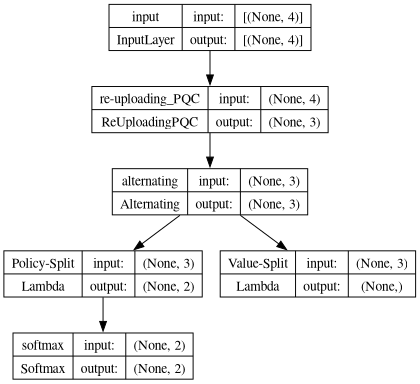

In [8]:
# Set the seed.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
#tf.debugging.disable_traceback_filtering()
env = gym.make("CartPole-v1")
agent = ActorCritic(0.01, 0.01, 0.9, env.observation_space.shape[0], env.action_space.n, 5)

tf.keras.utils.plot_model(agent.model, show_shapes=True, dpi=70)

#agent = ActorCritic(1e-2, 1e-2, 0, 0.9, 4, 2, [128], 'relu')

In [9]:
#tf.keras.utils.plot_model(agent.critic, show_shapes=True, dpi=70)

In [10]:

# get average reward during training episodes and plot.
total_rewards = []
average_rewards = []
episode_lengths = []

max_steps = 500
max_episodes = 5000
episode_average = 50
episode_threshold = 480

state_bounds = np.array([2.4, 2.5, 0.21, 2.5])

for episode in range(max_episodes):
  observation = env.reset()
  done = False
  total_reward = 0.0
  step = 0
  while step != max_steps and not done:
    # Calculate action
    action = agent.act(observation)

    # step forward
    new_observation, reward, done, info = env.step(action)
    new_observation = new_observation / state_bounds
    angle = observation[2]
    position = observation[0]
    #reward = 0.05 * (4.8 - np.abs(position)) / 4.8 + 0.95 * (12/np.pi) * (np.pi/12 - np.abs(angle)) 
    #reward = 0.1 * ((4.8 - np.abs(position))/4.8)**2 + 0.9 * ((np.pi/12 - np.abs(angle))/(np.pi/12))**3 
    #reward = 0.05 * ((4.8 - np.abs(position))/4.8)**2 + 0.95 * ((np.pi/12 - np.abs(angle))/(np.pi/12))**2 
    reward = 0.25 * (1 - np.abs(position))**3 + 0.75 * (1 - np.abs(angle))**3
    agent.learn(observation, action, reward, new_observation, done)

    # Update:
    total_reward += reward
    observation = new_observation
    step += 1

  agent.memory = []
  total_rewards.append(total_reward)
  average_rewards.append(total_reward / step)
  episode_lengths.append(step)
  average_episode_length = np.mean(episode_lengths[-episode_average:])

  if len(episode_lengths) > episode_average and average_episode_length > episode_threshold:
    print(f"\nSolved at Episode {episode}, Average Episode Length: {average_episode_length:.1f}")
    break
  else:
    print(f"\rEpisode: {episode}, Steps: {step: >3}, Average Episode Length: {average_episode_length: >4.1f}", end='')

Episode: 385, Steps: 500, Average Episode Length: 479.9
Solved at Episode 386, Average Episode Length: 481.3


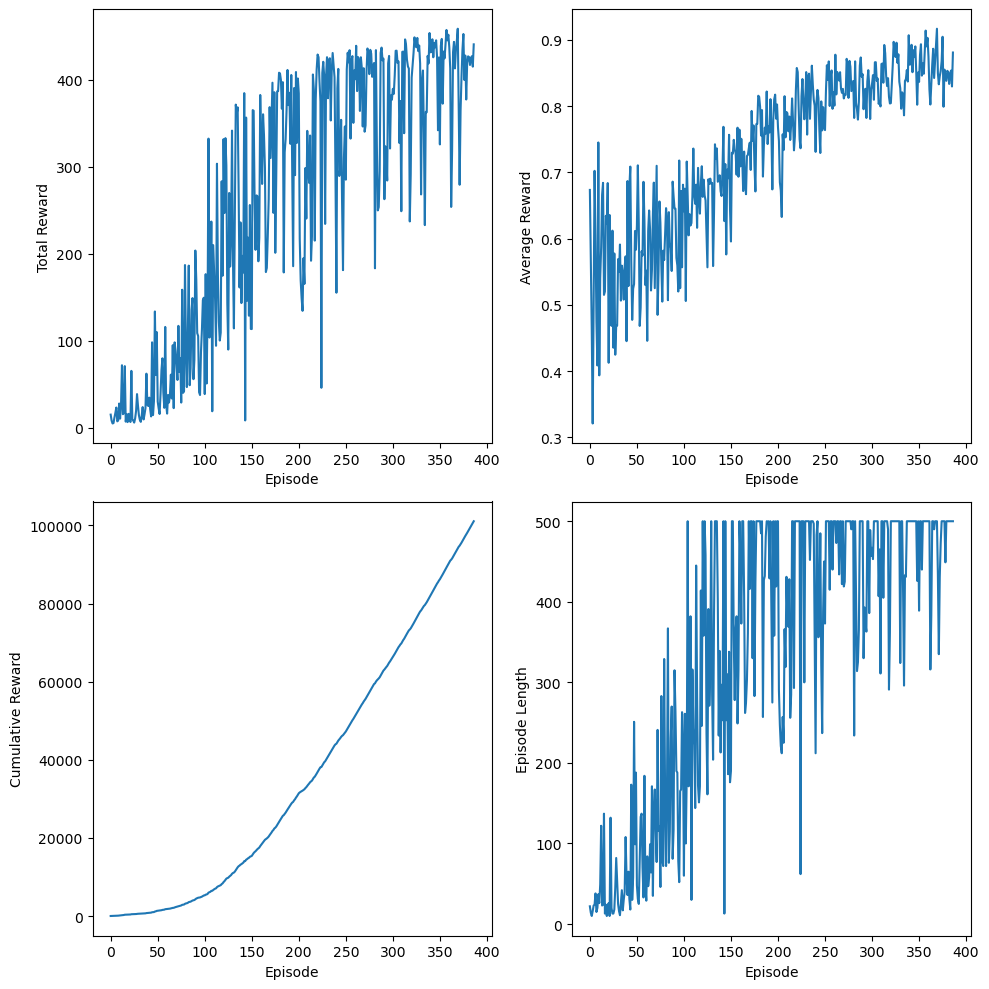

In [11]:
# ts = '2024.07.04-17.27'
# results = np.load(f'results_{ts}.npy', allow_pickle=True)
# total_rewards = results.item().get("Total Reward")
# average_rewards = results.item().get("Average Reward")
# episode_lengths = results.item().get("Episode Length")

fig, ax = plt.subplots(2, 2, figsize=(10, 10))

ax[0][0].set_xlabel('Episode')
ax[0][0].set_ylabel('Total Reward')
ax[0][0].plot(total_rewards)
#total_rewards_rolling = np.convolve(total_rewards, np.ones(len(total_rewards)//10), 'same') / (len(total_rewards)//10)
# cumsum_vec = np.cumsum(np.insert(total_rewards, 0, 0)) 
# total_rewards_rolling = (cumsum_vec[len(total_rewards)//10:] - cumsum_vec[:-len(total_rewards)//10 + 1]) / (len(total_rewards)//10)
# ax[0][0].plot(total_rewards_rolling)

ax[0][1].set_xlabel('Episode')
ax[0][1].set_ylabel('Average Reward')
ax[0][1].plot(average_rewards)
# cumsum_vec = np.cumsum(np.insert(average_rewards, 0, 0)) 
# average_rewards_rolling = (cumsum_vec[len(average_rewards)//10:] - cumsum_vec[:-len(average_rewards)//10 + 1]) / (len(average_rewards)//10)
# ax[0][1].plot(average_rewards_rolling)

ax[1][0].set_xlabel('Episode')
ax[1][0].set_ylabel('Cumulative Reward')
cumulative_rewards = np.cumsum(total_rewards)
ax[1][0].plot(cumulative_rewards)

ax[1][1].set_xlabel('Episode')
ax[1][1].set_ylabel('Episode Length')
ax[1][1].plot(episode_lengths, label='Lengths')
# cumsum_vec = np.cumsum(np.insert(episode_lengths, 0, 0)) 
# episode_lengths_rolling = (cumsum_vec[len(episode_lengths)//10:] - cumsum_vec[:-len(episode_lengths)//10 + 1]) / (len(episode_lengths)//10)
# ax[1][1].plot(episode_lengths_rolling, 'b--', label='Smoothed Lengths')
# ax[1][1].legend()

fig.tight_layout()
plt.show()

In [15]:
import time
timestamp = time.strftime("%Y.%m.%d-%H.%M")
#np.save(f'total_reward_{timestamp}.npy', total_rewards)
#np.save(f'running_reward_{timestamp}.npy', running_rewards)
#np.save(f'average_reward_{timestamp}.npy', average_rewards)
results = {"Total Reward":total_rewards,
           "Cumulative Reward": np.cumsum(total_rewards),
           "Average Reward": average_rewards,
           "Episode Length": episode_lengths}
np.save(f'qresults_{timestamp}.npy', results)
agent.save(timestamp)

NotImplementedError: 
Layer ReUploadingPQC was created by passing
non-serializable argument values in `__init__()`,
and therefore the layer must override `get_config()` in
order to be serializable. Please implement `get_config()`.

Example:

class CustomLayer(keras.layers.Layer):
    def __init__(self, arg1, arg2, **kwargs):
        super().__init__(**kwargs)
        self.arg1 = arg1
        self.arg2 = arg2

    def get_config(self):
        config = super().get_config()
        config.update({
            "arg1": self.arg1,
            "arg2": self.arg2,
        })
        return config


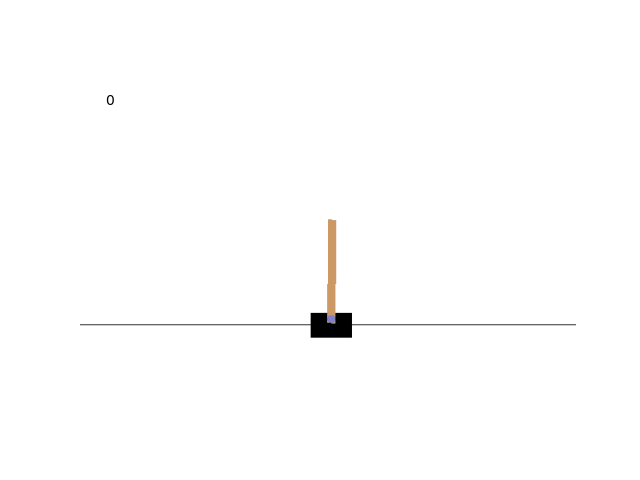

In [22]:
# Play:
import matplotlib.animation as anim
import tensorflow_docs.vis.embed as embed

actor = agent.actor #keras.models.load_model(f"actor_{timestamp}.keras", compile=False)

env = gym.make('CartPole-v1')
observation = env.reset()

frames=[]
for i in range(500):
  frames.append(env.render(mode='rgb_array'))
  observation = observation / state_bounds
  action = np.random.choice(env.action_space.n,
                                p=actor.predict(observation[np.newaxis, :],
                                                 verbose=False).flatten())
  observation, _, done, _ = env.step(action)
  if done:
      break

env.close()

def init():
    global im, text
    im = ax.imshow(frames[0])
    text = ax.text(.05, .95, '1', ha='left',
                   va='top', transform=ax.transAxes) 

def animate(i):
  global im, text
  im.set_data(frames[i])
  text.set_text(str(i))

fig = plt.figure()
ax = plt.gca()
ax.axis('off')

animation = anim.FuncAnimation(fig, animate, init_func=init, frames=len(frames))
animation.save(f'animation_{timestamp}.gif', writer='ffmpeg', fps=30)
plt.close(fig)
embed.embed_file(f'animation_{timestamp}.gif')